# Test Environment

In [32]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import pandas as pd
#import Models.models as models
#import Models.LSTM.models_LSTM as models
import myLibrary as mL
#from Experiment_Class import Experiment
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import os

NDBC = mL.NDBC_lib
ERA5 = mL.ERA5_lib
Models = mL.Models
DP = mL.DataProcessor
Experiment = mL.Experiment

# Get Data

In [33]:
data_directory = os.path.join(os.getcwd(), f'data/datasets/type_A')

def build_UI():

    # Select Model-------------------------------------------------------------------------------
    global datafile_widget
    datafile_list = os.listdir(data_directory)
    datafile_widget = widgets.Select(
        options=datafile_list,
        value=datafile_list[0],
        # rows=10,
        description='Datafile:',
        disabled=False
    )
    display(datafile_widget)

    #STATIONARY_SHIFT -----------------------------------------------------------------------
    global stationaryShift_widget
    stationaryShift_widget = widgets.BoundedIntText(
        value=1,
        min=0,
        max=10,
        step=1,
        description='',
        disabled=False,
    )
    print("Stationary Shilft: ")
    display(stationaryShift_widget)

    # Test Hours-------------------------------------------------------------------------------
    global test_hours_widget
    test_hours_widget = widgets.IntSlider(
        value=24,
        min=0,
        max=1000,
        step=1,
        description='Test Hours:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )

    # display the range slider widget
    display(test_hours_widget)
    #print("(1 Week = 168h)")

    # Select Model-------------------------------------------------------------------------------
    global models_widget
    models_list = list(Models.model_dictionary.keys())
    models_widget = widgets.Select(
        options=models_list,
        value=models_list[0],
        # rows=10,
        description='Model:',
        disabled=False
    )
    display(models_widget)

    #ALPHA:-------------------------------------------------------------------------------
    # create a FloatSlider widget for a value between 0 and 1
    print("Alpha (only for PINN):")
    global alpha_slider
    alpha_slider = widgets.FloatSlider(
        value=0.5,
        min=0,
        max=1,
        step=0.01,
        description='',
        readout_format='.2f',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    # display the FloatSlider widget
    display(alpha_slider)


build_UI()

Select(description='Datafile:', options=('.DS_Store', 'dataset_1_A.pickle'), value='.DS_Store')

Stationary Shilft: 


BoundedIntText(value=1, max=10)

LAG:


BoundedIntText(value=1, max=10)

IntSlider(value=24, continuous_update=False, description='Test Hours:', max=1000)

Select(description='Model:', options=('lstm_0', 'lstm_1', 'lstm_2', 'pinn_0', 'pinn_1'), value='lstm_0')

Alpha (only for PINN):


FloatSlider(value=0.5, layout=Layout(width='500px'), max=1.0, step=0.01)

In [8]:
DATAFILE = datafile_widget.value
STATIONARY_SHIFT = stationaryShift_widget.value
N_TEST_HOURS = test_hours_widget.value
MODEL_NAME = models_widget.value
ALPHA = alpha_slider.value

## Optional: use hardcoded variables instead

In [16]:
DATAFILE = "dataset_1_A.pickle"
STATIONARY_SHIFT = 1
N_TEST_HOURS = 24
MODEL_NAME = "pinn_1"
ALPHA = 0.5

In [17]:
print(f"Datafile: {DATAFILE}")
print(f"Alpha: {ALPHA}")
print(f"Stationary Shift: {STATIONARY_SHIFT}")
print(f"Test-Hours: {N_TEST_HOURS}")
print(f"Model: {MODEL_NAME}")

Datafile: dataset_1_A.pickle
Alpha: 0.5
Stationary Shift: 1
LAG: 1
Test-Hours: 24
Model: pinn_1


In [18]:
with open(f'data/datasets/type_A/{DATAFILE}', 'rb') as f:
    # load the object from the file using pickle.load()
    dataset = pickle.load(f)

print("stations",dataset["stations"])
print("years",dataset["years"])
print("nan_threshold",dataset["nan_threshold"])
print("features",dataset["features"])
print("add_era5",dataset["add_era5"])

data = dataset["data"]
data

stations ['41117']
years ['2022']
nan_threshold 0.5
features ['ATMP', 'WTMP']
add_era5 True


,ATMP_41117,WTMP_41117,ATMP_41117_ERA5,WTMP_41117_ERA5
timestamp,,,,
2022-01-01 00:00:00,20.8,20.6,21.629668,20.254283
2022-01-01 01:00:00,20.8,20.6,21.576521,20.254283
2022-01-01 02:00:00,20.8,20.5,21.481707,20.254283
2022-01-01 03:00:00,20.8,20.5,21.298031,20.254283
2022-01-01 04:00:00,20.7,20.4,21.101175,20.254283
...,...,...,...,...
2022-12-31 19:00:00,18.1,17.4,20.968520,18.848540
2022-12-31 20:00:00,18.3,17.4,21.142417,18.848540
2022-12-31 21:00:00,18.7,17.4,21.182383,18.848540


# Data Processing

## 1. Make data stationary

In [19]:
STATIONARY = True #Set Flag for report
data_stationary = DP.data_to_stationary(data, n = STATIONARY_SHIFT)
data_stationary.head()

,ATMP_41117,WTMP_41117,ATMP_41117_ERA5,WTMP_41117_ERA5
timestamp,,,,
2022-01-01 01:00:00,0.0,0.0,-0.053147,0.0
2022-01-01 02:00:00,0.0,-0.1,-0.094814,0.0
2022-01-01 03:00:00,0.0,0.0,-0.183676,0.0
2022-01-01 04:00:00,-0.1,-0.1,-0.196856,0.0
2022-01-01 05:00:00,0.1,0.0,-0.185377,0.0


## 2. Transform to supervised problem

In [20]:
data_supervised = DP.data_to_supervised(data_stationary)
data_supervised.head()

,ATMP_41117(t-1),WTMP_41117(t-1),ATMP_41117_ERA5(t-1),WTMP_41117_ERA5(t-1),ATMP_41117(t),WTMP_41117(t),ATMP_41117_ERA5(t),WTMP_41117_ERA5(t)
timestamp,,,,,,,,
2022-01-01 02:00:00,0.0,0.0,-0.053147,0.0,0.0,-0.1,-0.094814,0.0
2022-01-01 03:00:00,0.0,-0.1,-0.094814,0.0,0.0,0.0,-0.183676,0.0
2022-01-01 04:00:00,0.0,0.0,-0.183676,0.0,-0.1,-0.1,-0.196856,0.0
2022-01-01 05:00:00,-0.1,-0.1,-0.196856,0.0,0.1,0.0,-0.185377,0.0
2022-01-01 06:00:00,0.1,0.0,-0.185377,0.0,-0.5,-0.1,-0.177723,0.0


## train test split

In [21]:
train_X, train_y, test_X, test_y = DP.train_test_split(data_supervised, N_TEST_HOURS)
print("Shapes: ", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

Shapes:  (8734, 1, 4) (8734, 4) (24, 1, 4) (24, 4)


## Normalize the data

In [22]:
# Scale the data
#NORMALIZED = True   #set flag for report
train_X_scaled, train_y_scaled, test_X_scaled, test_y_scaled, SCALER = DP.scale_data(train_X,
                                                                                     train_y,
                                                                                     test_X,
                                                                                     test_y)

---
# Select Model

In [23]:
#model = models.lstm_0(train_X_scaled,train_y_scaled)
model = Models.get_model(MODEL_NAME, train_X, train_y, ALPHA)
model.summary()

2023-05-09 13:51:14.224349: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            68096     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 130,052
Trainable params: 130,052
Non-trai

----
# One-Shot Forecasting

In [24]:
_ = model.predict(train_X_scaled, batch_size=1)

8734/8734 [==============================] - 5s 476us/step


In [25]:
output_cols = data.columns.tolist()
output_cols

['ATMP_41117', 'WTMP_41117', 'ATMP_41117_ERA5', 'WTMP_41117_ERA5']

In [26]:
yhat = model.predict(test_X_scaled)
yhat_unscaled = DP.invert_scaling(yhat, SCALER)
yhat_unscaled_df = pd.DataFrame(yhat_unscaled, columns=[name + "_pred" for name in output_cols])
yhat_unscaled_df.set_index(data.tail(len(yhat)).index, inplace=True)
yhat_unscaled_df

1/1 [==============================] - 0s 440ms/step


,ATMP_41117_pred,WTMP_41117_pred,ATMP_41117_ERA5_pred,WTMP_41117_ERA5_pred
timestamp,,,,
2022-12-31 00:00:00,-0.745772,0.066308,-0.533751,0.051017
2022-12-31 01:00:00,-0.547978,0.100826,-0.444131,0.050303
2022-12-31 02:00:00,-0.665565,0.111724,-0.559995,0.051030
2022-12-31 03:00:00,-0.583372,0.114828,-0.530153,0.050526
2022-12-31 04:00:00,-0.752897,0.079622,-0.611200,0.051076
2022-12-31 05:00:00,-0.701021,0.125799,-0.657817,0.051377
2022-12-31 06:00:00,-0.685145,0.132493,-0.695347,0.051401
2022-12-31 07:00:00,-0.503511,0.180313,-0.650980,0.050956
2022-12-31 08:00:00,-0.769937,0.134000,-0.750834,0.051934


In [30]:
evaluation_1 = data.tail(len(yhat)+1).copy()  #+1 since i need that value for de-differencing
evaluation_1

,ATMP_41117,WTMP_41117,ATMP_41117_ERA5,WTMP_41117_ERA5
timestamp,,,,
2022-12-30 23:00:00,18.4,17.7,18.813730,18.84854
2022-12-31 00:00:00,18.6,17.7,19.761872,18.84854
2022-12-31 01:00:00,18.4,17.7,20.323103,18.84854
2022-12-31 02:00:00,18.5,17.7,20.752531,18.84854
2022-12-31 03:00:00,18.6,17.6,21.043351,18.84854
2022-12-31 04:00:00,18.4,17.6,21.118182,18.84854
2022-12-31 05:00:00,18.4,17.6,20.974047,18.84854
2022-12-31 06:00:00,18.6,17.7,20.761460,18.84854
2022-12-31 07:00:00,18.3,17.7,20.570130,18.84854


In [31]:
for col in evaluation_1.columns:
    evaluation_1[f"{col}_pred"]= evaluation_1[col].shift(STATIONARY_SHIFT) + yhat_unscaled_df[f"{col}_pred"]

evaluation_1 = evaluation_1.iloc[STATIONARY_SHIFT:]  # remove first n entries since there is no delta value for them
evaluation_1

,ATMP_41117,WTMP_41117,ATMP_41117_ERA5,WTMP_41117_ERA5,ATMP_41117_pred,WTMP_41117_pred,ATMP_41117_ERA5_pred,WTMP_41117_ERA5_pred
timestamp,,,,,,,,
2022-12-31 00:00:00,18.6,17.7,19.761872,18.84854,17.654228,17.766308,18.279979,18.899557
2022-12-31 01:00:00,18.4,17.7,20.323103,18.84854,18.052022,17.800826,19.317740,18.898843
2022-12-31 02:00:00,18.5,17.7,20.752531,18.84854,17.734435,17.811724,19.763109,18.899571
2022-12-31 03:00:00,18.6,17.6,21.043351,18.84854,17.916628,17.814828,20.222378,18.899066
2022-12-31 04:00:00,18.4,17.6,21.118182,18.84854,17.847103,17.679622,20.432151,18.899616
2022-12-31 05:00:00,18.4,17.6,20.974047,18.84854,17.698979,17.725799,20.460365,18.899917
2022-12-31 06:00:00,18.6,17.7,20.761460,18.84854,17.714855,17.732493,20.278701,18.899941
2022-12-31 07:00:00,18.3,17.7,20.570130,18.84854,18.096489,17.880313,20.110480,18.899496
2022-12-31 08:00:00,18.6,17.5,20.344362,18.84854,17.530063,17.834000,19.819296,18.900474


In [112]:
wtmp_true = [col for col in evaluation_1.columns if col.startswith("WTMP")][0]

mae = mean_absolute_error(evaluation_1[wtmp_true], evaluation_1[f"{wtmp_true}_pred"])
mse = mean_squared_error(evaluation_1[wtmp_true], evaluation_1[f"{wtmp_true}_pred"])
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  0.1402010140990439
MSE:  0.02565147800465928


<AxesSubplot:xlabel='timestamp'>

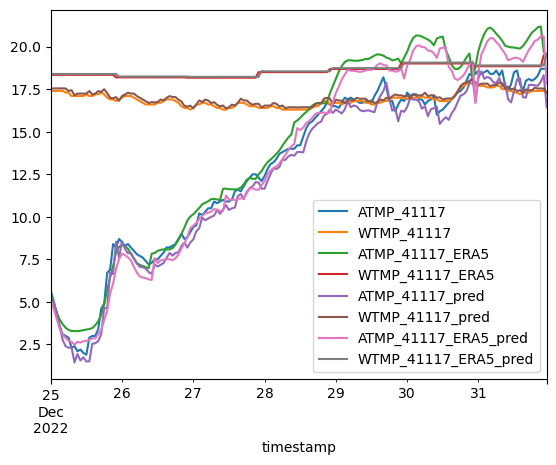

In [113]:
evaluation_1.plot(kind='line')

# Recurrent forecast

In [114]:
model.reset_states()
_ = model.predict(train_X_scaled, batch_size=1)

8590/8590 [==============================] - 3s 378us/step


In [115]:
# make a one-step forecast
# This function helps with reshaping.
def single_forecast(model, x):
    x = x.reshape(1, 1, len(x[0]))
    yhat = model.predict(x, verbose=0)
    return yhat

In [116]:
# Prepare data structure
prediction_2 = pd.DataFrame(test_y_scaled, columns=output_cols)
for col in output_cols:
    prediction_2[f"{col}_pred"] = 0

prediction_2

,ATMP_41117,WTMP_41117,ATMP_41117_ERA5,WTMP_41117_ERA5,ATMP_41117_pred,WTMP_41117_pred,ATMP_41117_ERA5_pred,WTMP_41117_ERA5_pred
0,0.252747,-0.185185,0.316879,-0.073070,0,0,0,0
1,0.076923,-0.185185,0.276999,-0.073070,0,0,0,0
2,0.098901,-0.185185,0.247577,-0.073070,0,0,0,0
3,0.054945,-0.185185,0.292059,-0.073070,0,0,0,0
4,0.120879,-0.185185,0.339469,-0.073070,0,0,0,0
...,...,...,...,...,...,...,...,...
163,0.252747,-0.185185,0.473332,-0.073070,0,0,0,0
164,0.274725,-0.185185,0.482814,-0.073070,0,0,0,0
165,0.318681,-0.185185,0.438890,-0.073070,0,0,0,0
166,0.230769,-0.185185,-0.066444,0.744012,0,0,0,0


,ATMP_41117,WTMP_41117,ATMP_41117_ERA5,WTMP_41117_ERA5,ATMP_41117_pred,WTMP_41117_pred,ATMP_41117_ERA5_pred,WTMP_41117_ERA5_pred
0,0.252747,-0.185185,0.316879,-0.073070,0.089257,-0.082697,0.185447,-0.009608
1,0.076923,-0.185185,0.276999,-0.073070,0.057794,-0.028184,0.092914,-0.006070
2,0.098901,-0.185185,0.247577,-0.073070,0.030651,-0.009082,0.046810,-0.004685
3,0.054945,-0.185185,0.292059,-0.073070,0.012419,-0.004158,0.021141,-0.004088
4,0.120879,-0.185185,0.339469,-0.073070,0.000632,-0.003590,0.006154,-0.003831
...,...,...,...,...,...,...,...,...
163,0.252747,-0.185185,0.473332,-0.073070,-0.018744,-0.005558,-0.016557,-0.003573
164,0.274725,-0.185185,0.482814,-0.073070,-0.018744,-0.005558,-0.016557,-0.003573
165,0.318681,-0.185185,0.438890,-0.073070,-0.018744,-0.005558,-0.016557,-0.003573
166,0.230769,-0.185185,-0.066444,0.744012,-0.018744,-0.005558,-0.016557,-0.003573


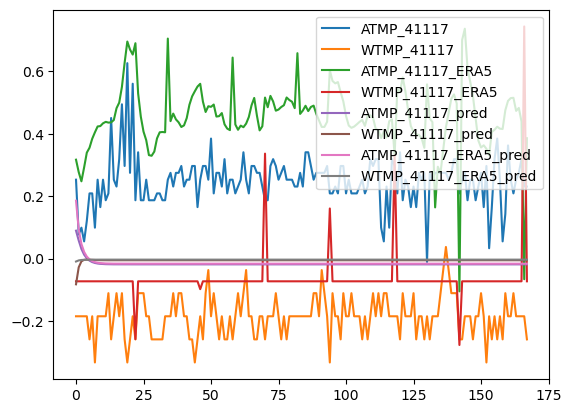

In [117]:
#Forecast a whole week
prev_obs = test_X_scaled[0]

for i, row in prediction_2.iterrows():
    yhat = single_forecast(model, prev_obs)
    prev_obs = yhat

    #Mapping of array index and df column name
    for j, element in enumerate(output_cols):
        prediction_2.at[i, f"{element}_pred"] =yhat[0,j]

prediction_2.plot(kind='line')
prediction_2

In [118]:
#Reverse differenciate
first_row = data.iloc[-len(yhat)-1]

yhat = prediction_2[[name + "_pred" for name in output_cols]].values
yhat_unscaled = DP.invert_scaling(yhat, SCALER)
yhat_true_value = DP.stationary_to_data(yhat_unscaled, first_row)

yhat_true_value_df = pd.DataFrame(yhat_true_value, columns=[name + "_pred" for name in output_cols])
yhat_true_value_df.set_index(data.tail(len(yhat)).index, inplace=True)

true_value = data.tail(len(yhat)+1).copy()

evaluation_2 = pd.concat([true_value, yhat_true_value_df], axis=1)
evaluation_2 = evaluation_2.iloc[STATIONARY_SHIFT:]
evaluation_2

,ATMP_41117,WTMP_41117,ATMP_41117_ERA5,WTMP_41117_ERA5,ATMP_41117_pred,WTMP_41117_pred,ATMP_41117_ERA5_pred,WTMP_41117_ERA5_pred
timestamp,,,,,,,,
2022-12-25 00:00:00,5.7,17.4,5.364998,18.343939,18.056118,17.538360,18.948694,19.550792
2022-12-25 01:00:00,5.0,17.4,4.911336,18.343939,17.269079,17.750311,17.933730,19.604226
2022-12-25 02:00:00,4.4,17.4,4.367961,18.343939,16.358542,17.988051,16.778187,19.658765
2022-12-25 03:00:00,3.6,17.4,3.960218,18.343939,15.365051,18.232438,15.544374,19.713781
2022-12-25 04:00:00,3.1,17.4,3.697034,18.343939,14.317927,18.477591,14.264865,19.769000
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,18.1,17.4,20.968520,18.848540,-166.053301,57.040383,-200.080882,28.581396
2022-12-31 20:00:00,18.3,17.4,21.142417,18.848540,-167.188588,57.282880,-201.429642,28.636822
2022-12-31 21:00:00,18.7,17.4,21.182383,18.848540,-168.323876,57.525377,-202.778401,28.692248


In [119]:
wtmp_true = [col for col in evaluation_2.columns if col.startswith("WTMP")][0]

mae_2 = mean_absolute_error(evaluation_2[wtmp_true], evaluation_2[f"{wtmp_true}_pred"])
mse_2 = mean_squared_error(evaluation_2[wtmp_true], evaluation_2[f"{wtmp_true}_pred"])
print('MAE: ', mae_2)
print('MSE: ', mse_2)

MAE:  20.86414866670229
MSE:  570.4864354274642


<AxesSubplot:xlabel='timestamp'>

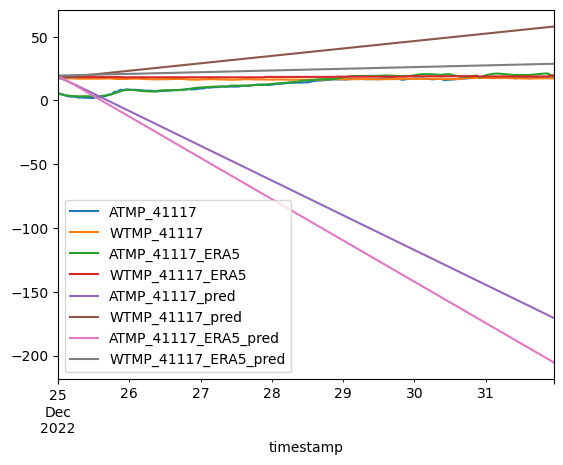

In [120]:
evaluation_2.plot(kind='line')

# SAVE

In [126]:
# create a text input widget for username
filename_widget = widgets.Text(
    value='',
    placeholder='Enter filename',
    description='Filename:',
    disabled=False
)
# add '.csv' to the description
extension_label = widgets.Label('.pickle')

# display the widget
display(widgets.HBox([filename_widget, extension_label]))

print("Please also check if the reports description needs to be changed!")

Please also check if the reports description needs to be changed!


In [129]:
report_description="Stations that provide all files from 2013-2022 in GOM"

In [131]:
filename = filename_widget.value
if filename == "":
    print("Enter a valid filename!")

else:
    #Save Data About executed Test:

    #Convert model summary to string
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    model_summary = "\n".join(stringlist)

    report = Experiment(
        name=filename,
        description=report_description,

        stations = dataset["stations"],
        years = dataset["years"],
        nan_threshold=dataset["nan_threshold"],
        features=dataset["features"],
        era5=dataset["add_era5"],

        stationary_shift=STATIONARY_SHIFT,

        n_test_hours=N_TEST_HOURS,

        #stationary=STATIONARY,
        scaler=SCALER,

        model_name = MODEL_NAME,
        model_summary=model_summary,

        one_shot_forecast = evaluation_1,
        recursive_forecast = evaluation_2
    )


    # open a file for writing in binary mode
    filepath = f'data/reports/{report.name}.pickle'
    with open(filepath, 'wb') as f:
        # write the object to the file using pickle.dump()
        pickle.dump(report, f)
        print("File successfully saved:")
        print(filepath)

File successfully saved:
data/reports/report_test.pickle
